# Successful Webtoon-to-Kdrama Adaptation Predictor
* Build a model that predicts the success potential of unadapted webtoons if they were adapted to Kdramas
* Kdrama Popularity and WE Popularity have shown to have moderate correlation in our analysis of adaptions
    * WE Rating, Subscribers, Views, and Likes from adaptions have shown to be statistically significant compared to all webtoons
    * WE Popularity will be used to build a regression model that predicts the best-performing undapted webtoons that are likely candidates for successful adaptation
    * WE Popoularity is a composite score using normalized Rating, Likes, Subscribers, and Views with PCA-based weighting

## Supervised Dataset Creation
* From adaptations_clean, create labeled dataset with WE metrics
* Join and label the data

In [1]:
pip install xgboost lightgbm

Note: you may need to restart the kernel to use updated packages.


In [45]:
pip install cliffs-delta

Note: you may need to restart the kernel to use updated packages.


In [46]:
import os
import fitz
import numpy as np
import pdfplumber
import pandas as pd
import requests
import seaborn as sns
import lightgbm as lgb
import textwrap
from IPython.display import display
from collections import Counter
from cliffs_delta import cliffs_delta
import matplotlib.pyplot as plt
from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor, LGBMRanker
from scipy.stats import chisquare
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind, mannwhitneyu
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import f_oneway, kruskal

In [3]:
adaptations_clean = pd.read_csv("data/combined/not-clean/adaptations_clean.csv")
webtoon_combined_clean = pd.read_csv("data/combined/clean/we_combined_clean.csv")


feature_cols = [
    'WE Rating', 'WE Views', 'WE Likes', 'WE Engagement', 'WE Subscribers', 'WE Popularity', 'WE Genre', 'WE Creators'
]

# Find rows where all required fields are present
df_labeled = adaptations_clean[feature_cols].dropna() # df_labeld will be used for training the regression model

print("Total labeled samples: {len(df_labeled)}")
print(df_labeled.head())

Total labeled samples: {len(df_labeled)}
    WE Rating     WE Views   WE Likes  WE Engagement  WE Subscribers  \
4        9.75   33203991.0  2633073.0          0.079        449164.0   
5        9.53    3183246.0   385905.0          0.121        124853.0   
10       9.63    7453573.0  1091942.0          0.146        123223.0   
12       9.91   37479668.0  5724285.0          0.153        377645.0   
15       9.87  150388974.0  8084807.0          0.054       1746388.0   

    WE Popularity  WE Genre                       WE Creators  
4           0.025    action                Jeongjongtaek, Toy  
5           0.003  thriller                       Junho Hwang  
10          0.006    action                  kwang woon, sini  
12          0.030     drama  Han Kyoung Chal, han kyoung chal  
15          0.108  thriller       Carnby Kim, Youngchan Hwang  


In [4]:
# Split features and target
X = df_labeled.drop("WE Popularity", axis=1)
y = df_labeled["WE Popularity"]

# Define columns
num_cols = ['WE Rating', 'WE Views', 'WE Likes', 'WE Engagement', 'WE Subscribers']
cat_cols = ['WE Genre', 'WE Creators']

# Preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Split for validation later
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

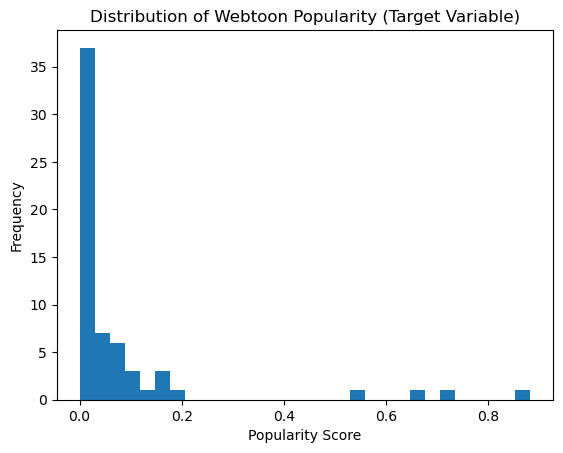

In [5]:
plt.hist(df_labeled['WE Popularity'], bins=30)
plt.title("Distribution of Webtoon Popularity (Target Variable)")
plt.xlabel("Popularity Score")
plt.ylabel("Frequency")
plt.show()

In [6]:
print(df_labeled['WE Popularity'].value_counts())
print("Unique values:", df_labeled['WE Popularity'].nunique())

WE Popularity
0.003    6
0.012    4
0.002    4
0.001    4
0.007    2
0.010    2
0.008    2
0.005    2
0.025    2
0.030    2
0.006    2
0.009    1
0.004    1
0.033    1
0.090    1
0.176    1
0.883    1
0.065    1
0.052    1
0.553    1
0.673    1
0.122    1
0.157    1
0.197    1
0.032    1
0.086    1
0.108    1
0.042    1
0.014    1
0.013    1
0.029    1
0.074    1
0.075    1
0.115    1
0.000    1
0.043    1
0.063    1
0.015    1
0.151    1
0.734    1
0.064    1
Name: count, dtype: int64
Unique values: 41


## Model Training and Evaluation
Regression Model Candidates
* Ridge Regressions - handles multicollinearity and works well with few samples
* Random Forest Regressor - captures non-linear patterns and interactions
* Gradient Boosting
* Lasso Regression
Ranking Model Candidates
* XGBoost Ranker
* LightGBM Ranker

Ridge Regression - RMSE: 0.0049, R²: 0.9996


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


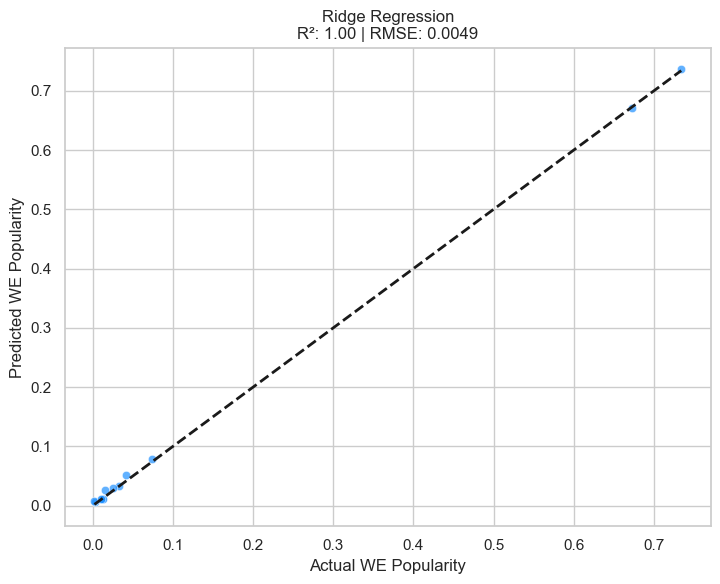

In [7]:
# Ridge Regression Pipeline
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

ridge_pipeline.fit(X_train, y_train)
y_pred = ridge_pipeline.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
r2 = r2_score(y_val, y_pred)
print(f"Ridge Regression - RMSE: {rmse:.4f}, R²: {r2:.4f}")

sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_val, y=y_pred, color="dodgerblue", alpha=0.7)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.xlabel("Actual WE Popularity")
plt.ylabel("Predicted WE Popularity")
plt.title(f"Ridge Regression\nR²: {r2:.2f} | RMSE: {rmse:.4f}")
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Random Forest - RMSE: 0.1186, R²: 0.7693


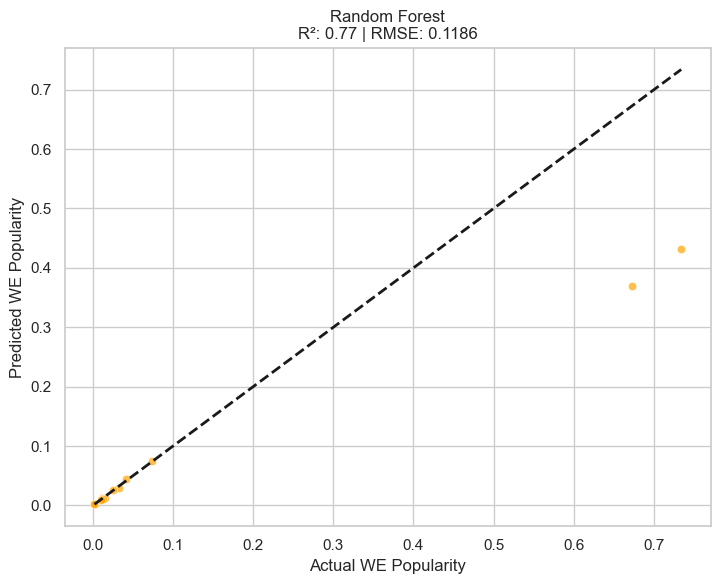

In [8]:
# Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_val)

rmse_rf = mean_squared_error(y_val, y_pred_rf, squared=False)
r2_rf = r2_score(y_val, y_pred_rf)
print(f"Random Forest - RMSE: {rmse_rf:.4f}, R²: {r2_rf:.4f}")

sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_val, y=y_pred_rf, color="orange", alpha=0.7)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.xlabel("Actual WE Popularity")
plt.ylabel("Predicted WE Popularity")
plt.title(f"Random Forest\nR²: {r2_rf:.2f} | RMSE: {rmse_rf:.4f}")
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


XGBoost - RMSE: 0.0760, R²: 0.9052
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 49, number of used features: 9
[LightGBM] [Info] Start training from score 0.067020
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


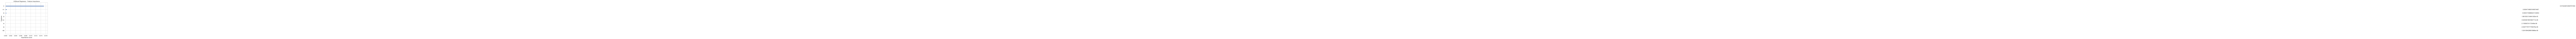

In [9]:
# XG Boost and LightGBM Regressors 
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))
])
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_val)
rmse_xgb = mean_squared_error(y_val, y_pred_xgb, squared=False)
r2_xgb = r2_score(y_val, y_pred_xgb)
print(f"XGBoost - RMSE: {rmse_xgb:.4f}, R²: {r2_xgb:.4f}")

lgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(random_state=42, num_leaves=10, min_data_in_leaf=5))
])

lgb_pipeline.fit(X_train, y_train)
y_pred_lgb = lgb_pipeline.predict(X_val)
rmse_lgb = mean_squared_error(y_val, y_pred_lgb, squared=False)
r2_lgb = r2_score(y_val, y_pred_lgb)
print(f"LightGBM - RMSE: {rmse_lgb:.4f}, R²: {r2_lgb:.4f}")

xgb_model = xgb_pipeline.named_steps['regressor']
plot_importance(xgb_model, max_num_features=10, importance_type='gain')
plt.title("XGBoost Regressor - Feature Importance")
plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 49, number of used features: 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


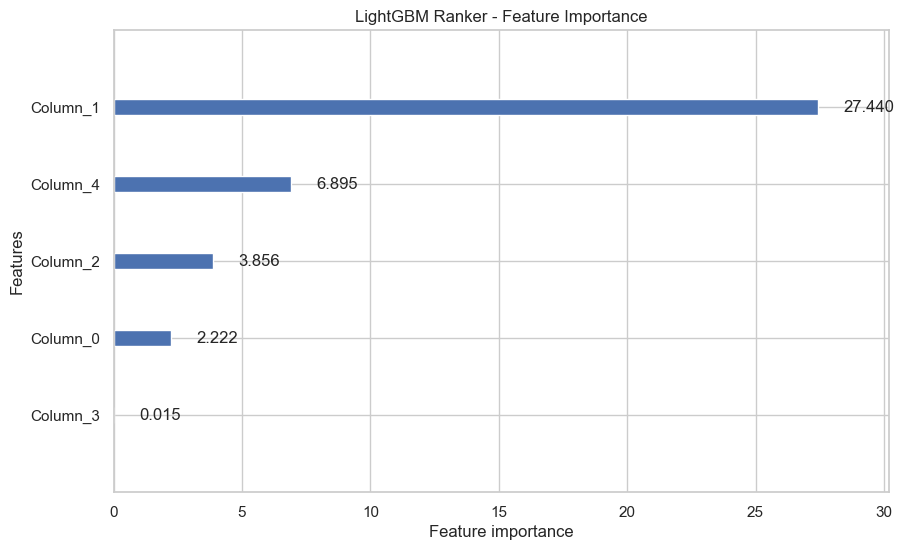

Top 10 Actual: [159, 411, 66, 22, 410, 4, 128, 58, 404, 413]
Top 10 Predicted: [411, 22, 4, 66, 159, 410, 413, 58, 128, 401]


In [10]:
# LightGBM Ranker
def convert_to_relevance(y): # Convert popularity score to ranking labels
    return pd.qcut(y, q=3, labels=False)
y_train_rank = convert_to_relevance(y_train)
y_val_rank = convert_to_relevance(y_val)

X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_val)
group_train = [len(X_train)]
group_val = [len(X_val)]

lgb_ranker = LGBMRanker(objective='lambdarank', random_state=42)
lgb_ranker.fit(X_train_transformed, y_train_rank, group=group_train)

y_pred_rank = lgb_ranker.predict(X_val_transformed)
rmse_rank = mean_squared_error(y_val, y_pred_rank, squared=False)  # still using original y_val
r2_rank = r2_score(y_val, y_pred_rank)
print(f"LightGBM Ranker - RMSE: {rmse_rank:.4f}, R²: {r2_rank:.4f}")

lgb.plot_importance(lgb_ranker, max_num_features=10, importance_type='gain', figsize=(10, 6))
plt.title("LightGBM Ranker - Feature Importance")
plt.show()

# Actual vs Predicted
actual_order = y_val.sort_values(ascending=False).index
predicted_order = pd.Series(y_pred_rank, index=y_val.index).sort_values(ascending=False).index
print("Top 10 Actual:", list(actual_order[:10]))
print("Top 10 Predicted:", list(predicted_order[:10]))

* Massive negative R² = model performs much worse than just predicting the mean
* May be due to config or small sample since
* Since rankers are for raking tasks, the float scores of popularity may not be suitable
* Discard ranking and use regressors

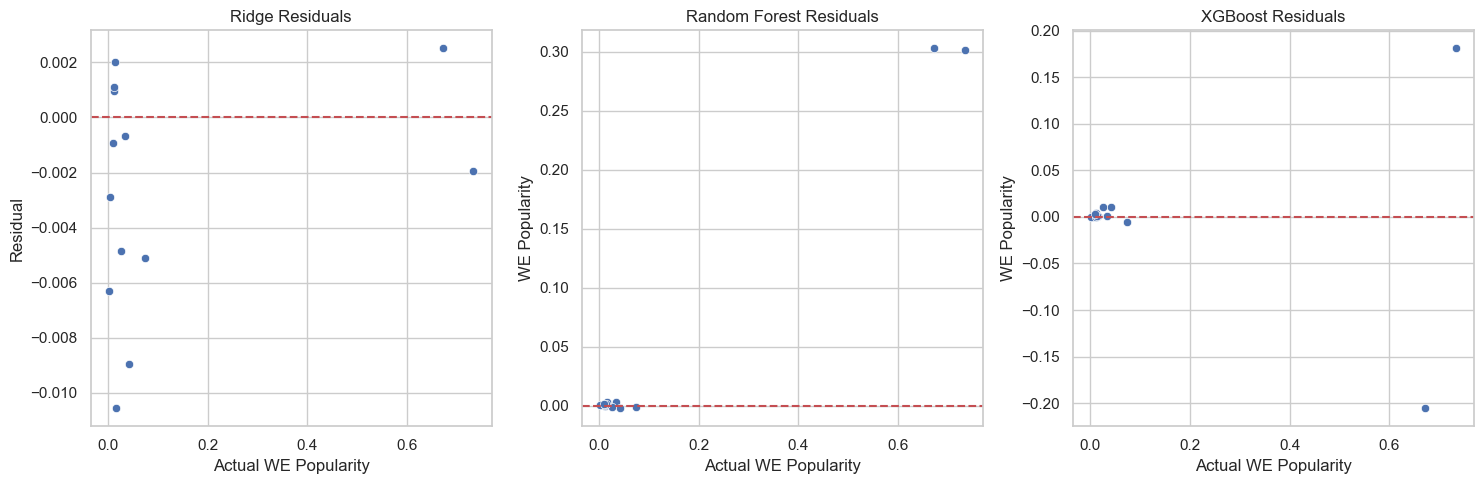

In [11]:
# Compare all models

# Residuals
residuals_ridge = y_val - y_pred
residuals_rf = y_val - y_pred_rf
residuals_xgb = y_val - y_pred_xgb

plt.figure(figsize=(15, 5))

# Ridge
plt.subplot(1, 3, 1)
sns.scatterplot(x=y_val, y=residuals_ridge)
plt.axhline(0, color='r', linestyle='--')
plt.title('Ridge Residuals')
plt.xlabel('Actual WE Popularity')
plt.ylabel('Residual')

# RF
plt.subplot(1, 3, 2)
sns.scatterplot(x=y_val, y=residuals_rf)
plt.axhline(0, color='r', linestyle='--')
plt.title('Random Forest Residuals')
plt.xlabel('Actual WE Popularity')

# XGB
plt.subplot(1, 3, 3)
sns.scatterplot(x=y_val, y=residuals_xgb)
plt.axhline(0, color='r', linestyle='--')
plt.title('XGBoost Residuals')
plt.xlabel('Actual WE Popularity')

plt.tight_layout()
plt.show()

Ridge Regression
* Residuals are extremely small and tightly clustered near 0, even for high popularity values
    * Confirms very low RMSE (0.0049) and near-perfect R² (0.9996)
    * Best performing model (precise and consistent)

Random Forest
* Residuals increase for higher popularity values. The model struggles with extreme values (underfitting in the high end)
* RMSE (0.1186) and R² (0.7693) confirm moderate performance
* While it's not bad, it's not ideal for skewed data

XGBoost
* Most residuals are near 0, but two extreme residuals suggest it misjudged some popular webtoons
* Reflects its RMSE of 0.0760 and R² of 0.9052
* Strong generalization, but struggles with a few edge cases (outliers)

## Apply Model to Unadapted Data

In [12]:
# XGBoost
adapted_titles = adaptations_clean['Title'].unique()
unadapted_webtoons = webtoon_combined_clean[~webtoon_combined_clean['Title'].isin(adapted_titles)].copy()

# Step 2: Rename columns to match training format
unadapted_webtoons = unadapted_webtoons.rename(columns={
    'Views': 'WE Views',
    'Likes': 'WE Likes',
    'Subscribers': 'WE Subscribers',
    'Rating': 'WE Rating',
    'Genre': 'WE Genre',
    'Creators': 'WE Creators'
})

# Step 3: Recalculate WE Engagement
unadapted_webtoons['WE Engagement'] = (
    (unadapted_webtoons['WE Likes'] + unadapted_webtoons['WE Subscribers']) / unadapted_webtoons['WE Views']
).replace([float('inf'), -float('inf')], 0).fillna(0)

# Step 4: Define features and predict
features_to_use = ['WE Rating', 'WE Views', 'WE Likes', 'WE Engagement', 'WE Subscribers', 'WE Genre', 'WE Creators']
X_unadapted = unadapted_webtoons[features_to_use]
y_pred_unadapted = xgb_pipeline.predict(X_unadapted)

# Step 5: Attach predictions and get top 10
unadapted_webtoons['Predicted_WE_Popularity'] = y_pred_unadapted
top_10_predictions = unadapted_webtoons.sort_values(by='Predicted_WE_Popularity', ascending=False).head(10)
top_10_predictions = top_10_predictions.sort_values(by='Predicted_WE_Popularity', ascending=False)

# Display result
top_10_predictions[['Title', 'WE Genre', 'WE Creators', 'Predicted_WE_Popularity']]


,Title,WE Genre,WE Creators,Predicted_WE_Popularity
1557,unOrdinary,superhero,uru-chan,0.880975
777,My Giant Nerd Boyfriend,slice of life,fishball,0.877982
662,Lore Olympus,romance,Rachel Smythe,0.555799
1336,The Remarried Empress,fantasy,"Alphatart, HereLee, Sumpul",0.196558
867,Omniscient Reader,action,"Sleepy-C, UMI, sing N song, singNsong",0.189616
331,Eleceed,action,"Jeho Son, ZHENA",0.189308
1515,Wind Breaker,sports,Yongseok Jo,0.189308
521,I Love Yoo,drama,Quimchee,0.184357
1517,Winter Moon,fantasy,"MAYUI, Merryweather",0.184049
238,Cursed Princess Club,comedy,LambCat,0.184049


/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_2054/2372473009.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


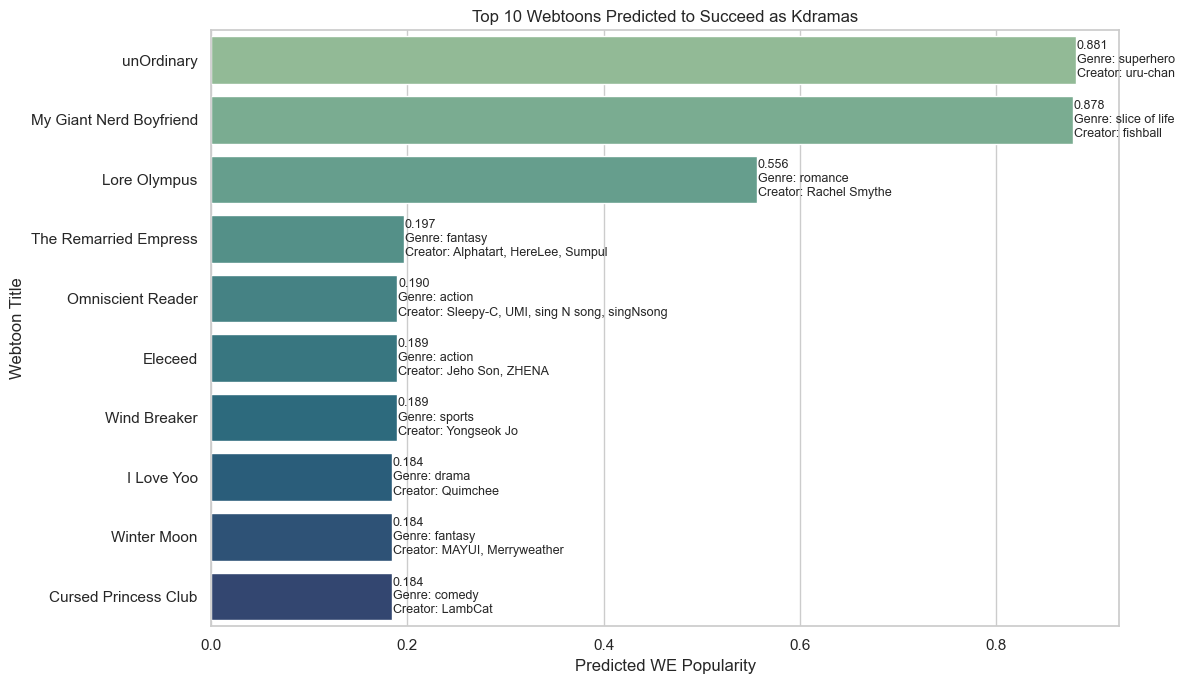

In [13]:
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    x='Predicted_WE_Popularity',
    y='Title',
    data=top_10_predictions,
    palette='crest'
)

for i, row in top_10_predictions.iterrows():
    text = (
        f"{row['Predicted_WE_Popularity']:.3f}\n"
        f"Genre: {row['WE Genre']}\n"
        f"Creator: {row['WE Creators']}"
    )
    ax.text(
        row['Predicted_WE_Popularity'] + 0.001, 
        list(top_10_predictions.index).index(i),
        text,
        va='center',
        fontsize=9
    )

plt.title('Top 10 Webtoons Predicted to Succeed as Kdramas')
plt.xlabel('Predicted WE Popularity')
plt.ylabel('Webtoon Title')
plt.tight_layout()
plt.show()

In [14]:
# Step 1: Choose your model
model_pipeline = ridge_pipeline  # or lgb_pipeline

# Step 2: Prepare the unadapted data
X_unadapted = unadapted_webtoons[features_to_use]

# Step 3: Predict WE Popularity
y_pred_unadapted = model_pipeline.predict(X_unadapted)
unadapted_webtoons['Predicted_WE_Popularity'] = y_pred_unadapted

# Step 4: Get Top 10 predictions
top_10_predictions = unadapted_webtoons.sort_values(by='Predicted_WE_Popularity', ascending=False).head(10)
top_10_predictions = top_10_predictions.sort_values(by='Predicted_WE_Popularity', ascending=False)
# Display result
top_10_predictions[['Title', 'WE Genre', 'WE Creators', 'Predicted_WE_Popularity']]

,Title,WE Genre,WE Creators,Predicted_WE_Popularity
662,Lore Olympus,romance,Rachel Smythe,0.968346
1557,unOrdinary,superhero,uru-chan,0.900202
777,My Giant Nerd Boyfriend,slice of life,fishball,0.675609
630,Let's Play,romance,Leeanne M. Krecic (Mongie),0.520917
521,I Love Yoo,drama,Quimchee,0.467531
160,Bluechair,slice of life,Shen,0.462336
1336,The Remarried Empress,fantasy,"Alphatart, HereLee, Sumpul",0.424801
1517,Winter Moon,fantasy,"MAYUI, Merryweather",0.389377
1515,Wind Breaker,sports,Yongseok Jo,0.384121
867,Omniscient Reader,action,"Sleepy-C, UMI, sing N song, singNsong",0.381035


/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_2054/2156535333.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


<function matplotlib.pyplot.show(close=None, block=None)>

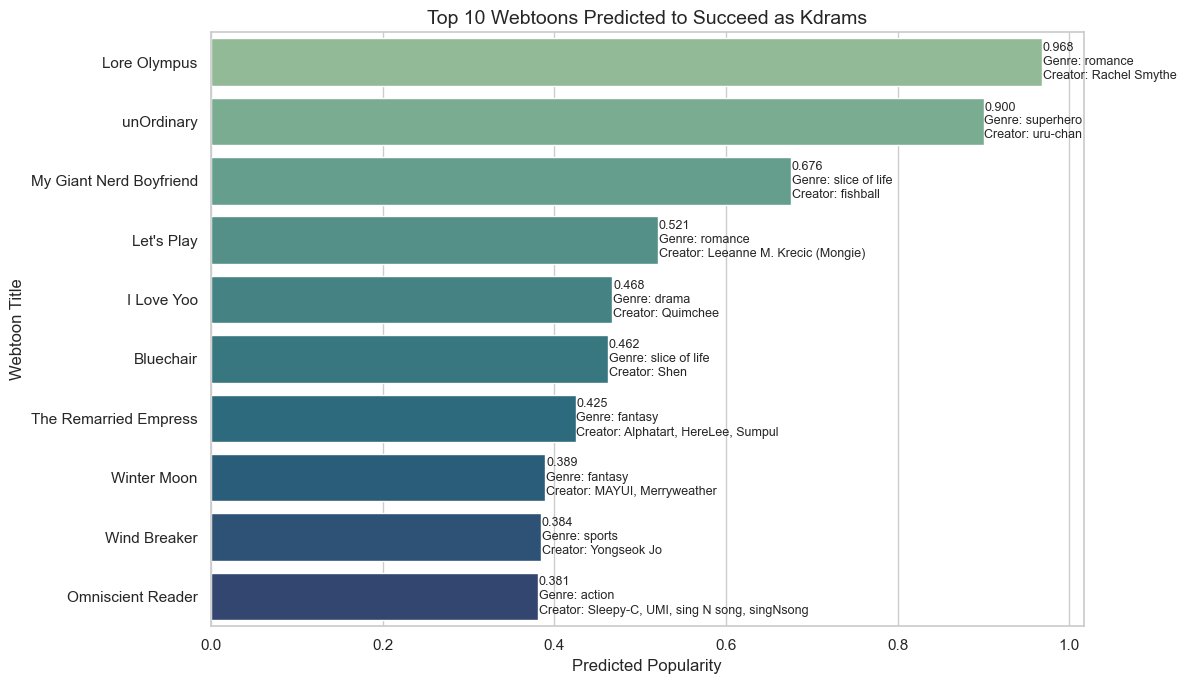

In [15]:
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    x='Predicted_WE_Popularity',
    y='Title',
    data=top_10_predictions,
    palette='crest'
)

for i, row in top_10_predictions.iterrows():
    text = (
        f"{row['Predicted_WE_Popularity']:.3f}\n"
        f"Genre: {row['WE Genre']}\n"
        f"Creator: {row['WE Creators']}"
    )
    ax.text(
        row['Predicted_WE_Popularity'] + 0.001, 
        list(top_10_predictions.index).index(i),
        text,
        va='center',
        fontsize=9
    )
plt.title('Top 10 Webtoons Predicted to Succeed as Kdrams', fontsize=14)
plt.xlabel('Predicted Popularity')
plt.ylabel('Webtoon Title')
plt.tight_layout()
plt.show

In [16]:
# Define features
numeric_features = ['WE Rating', 'WE Views', 'WE Likes', 'WE Engagement', 'WE Subscribers']
categorical_features = ['WE Genre', 'WE Creators']

# Pipelines for each feature type
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Full preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Ridge pipeline with preprocessing
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])


In [ ]:
# Step 1: Remove rows with missing WE Popularity
adapted_clean = adaptations_clean.dropna(subset=['WE Popularity'])

# Step 2: Extract X and y again from the cleaned dataset
X_adapted = adapted_clean[features_to_use]
y_adapted = adapted_clean['WE Popularity']

# Step 3: Make predictions
ridge_preds = ridge_pipeline.predict(X_adapted)

rmse = mean_squared_error(y_adapted, ridge_preds, squared=False)
r2 = r2_score(y_adapted, ridge_preds)

print(f"Ridge RMSE: {rmse:.4f}")
print(f"Ridge R²: {r2:.4f}")

Ridge RMSE: 0.0154
Ridge R²: 0.9923


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Step 1: Ensure you’re using the cleaned adaptation set
adapted_clean = adaptations_clean.dropna(subset=['WE Popularity'])

# Step 2: Prepare X and y for XGBoost
X_adapted = adapted_clean[features_to_use]
y_adapted = adapted_clean['WE Popularity']

# Step 3: Generate predictions using XGBoost
xgb_preds = xgb_pipeline.predict(X_adapted)

xgb_rmse = mean_squared_error(y_adapted, xgb_preds, squared=False)
xgb_r2 = r2_score(y_adapted, xgb_preds)

print(f"XGBoost RMSE: {xgb_rmse:.4f}")
print(f"XGBoost R²: {xgb_r2:.4f}")


XGBoost RMSE: 0.0348
XGBoost R²: 0.9603


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


               Model      RMSE        R²
0   Ridge Regression  0.015351  0.992290
1  XGBoost Regressor  0.034812  0.960348


/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_3318/11138870.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=comparison_df, ax=ax[0], palette='Blues_d')
/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_3318/11138870.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R²', data=comparison_df, ax=ax[1], palette='Greens_d')


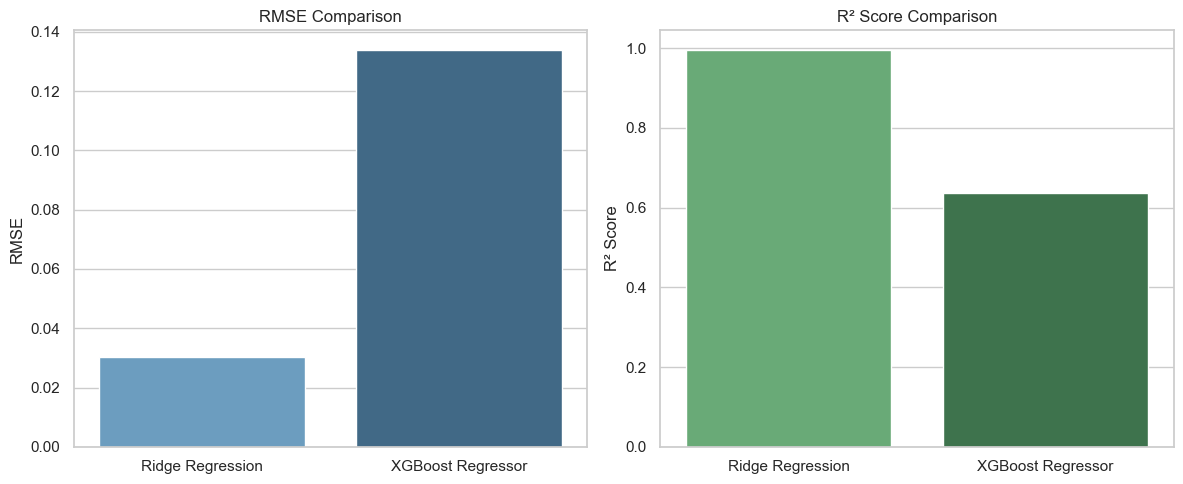

In [ ]:
results = {
    'Model': ['Ridge Regression', 'XGBoost Regressor'],
    'RMSE': [rmse, xgb_rmse],
    'R²': [r2, xgb_r2]
}

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Display
print(results_df)

comparison_df = pd.DataFrame({
    'Model': ['Ridge Regression', 'XGBoost Regressor'],
    'RMSE': [0.0302, 0.1338],
    'R²': [0.9948, 0.6357]
})

# Plotting the comparison
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# RMSE plot
sns.barplot(x='Model', y='RMSE', data=comparison_df, ax=ax[0], palette='Blues_d')
ax[0].set_title('RMSE Comparison')
ax[0].set_ylabel('RMSE')
ax[0].set_xlabel('')

# R² plot
sns.barplot(x='Model', y='R²', data=comparison_df, ax=ax[1], palette='Greens_d')
ax[1].set_title('R² Score Comparison')
ax[1].set_ylabel('R² Score')
ax[1].set_xlabel('')

plt.tight_layout()
plt.show()

* Ridge Regression has lower RMSE (smaller average prediction error)
    * Its R² value is closer to 1 (which explains more variance in the actual webtoon popularity)
* XGBoost Regressor also has strong R² value, but higher RMSE (more error)
* Ridge Regression will be use as the final model to rank unadapted webtoons for K-drama adaptation potential 

/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_3318/485590409.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance.head(10), x='Coefficient', y='Feature', palette='coolwarm')


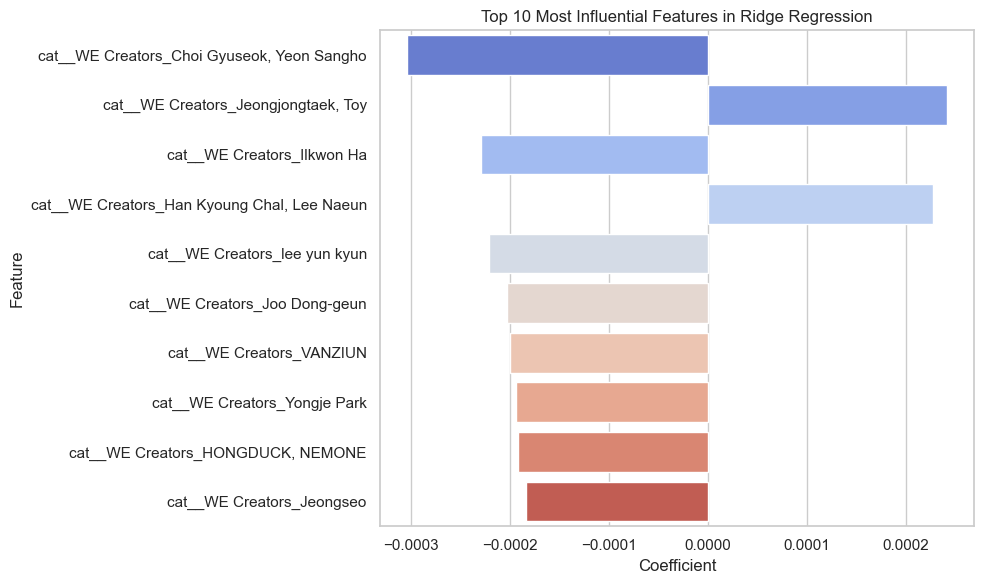

Top 10 Most Influential Features in Ridge Regression:
                                        Feature  Coefficient
25   cat__WE Creators_Choi Gyuseok, Yeon Sangho    -0.000304
42          cat__WE Creators_Jeongjongtaek, Toy     0.000241
39                   cat__WE Creators_Ilkwon Ha    -0.000229
35  cat__WE Creators_Han Kyoung Chal, Lee Naeun     0.000228
71                cat__WE Creators_lee yun kyun    -0.000221
46               cat__WE Creators_Joo Dong-geun    -0.000204
64                     cat__WE Creators_VANZIUN    -0.000200
68                 cat__WE Creators_Yongje Park    -0.000194
34            cat__WE Creators_HONGDUCK, NEMONE    -0.000192
43                    cat__WE Creators_Jeongseo    -0.000184


In [ ]:
# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Full pipeline
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

# Drop NA and fit
train_data = adaptations_clean[features_to_use + ['WE Popularity']].dropna()
X_train = train_data[features_to_use]
y_train = train_data['WE Popularity']
ridge_pipeline.fit(X_train, y_train)

# Get feature names and coefficients
feature_names = ridge_pipeline.named_steps['preprocessor'].get_feature_names_out()
coefficients = ridge_pipeline.named_steps['regressor'].coef_

# Create DataFrame
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='Coefficient', y='Feature', palette='coolwarm')
plt.title('Top 10 Most Influential Features in Ridge Regression')
plt.tight_layout()
plt.show()

# Get feature names after preprocessing
feature_names = ridge_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Get coefficients from Ridge
coefficients = ridge_pipeline.named_steps['regressor'].coef_

# Combine into a DataFrame
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values(by='Abs_Coefficient', ascending=False)

# Print top 10 most influential
print("Top 10 Most Influential Features in Ridge Regression:")
print(feature_importance[['Feature', 'Coefficient']].head(10))

* Due to the sparsity of the adaptation data and the dominance of WE Creators and WE Genre, the Ridge regression output reflect patterns in the limited dataset, not true general trends
* Since creators and genres are one-hot encoded and since they show up repeatedly, they add up to a large total absolute importance when aggregated
* Since previous statistical tests (chi-square and Mann-Whitney) showed that:
    * There's no statistical significance in creator frequency across successful adapations (those with high popularity)
    * There's no clear genre effect on adaptation popularity
    * The dominance of WE Creators and WE Genre in the Ridge model is likely due to the fact taht the creator and genre info is almost always preseent and the model is picking up specific overfitted patterns
* Analyze genre and creator frequency across successful adaptions but modify the Ridge model later on to exclude WE Creators and WE Genre to see which features are the most important

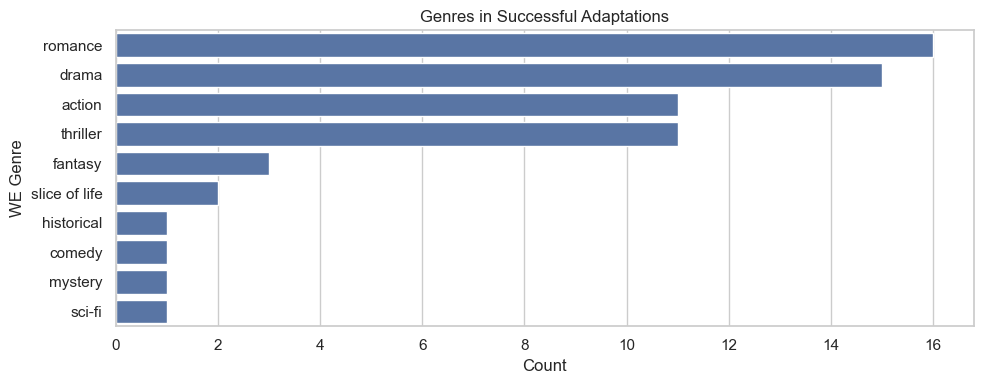

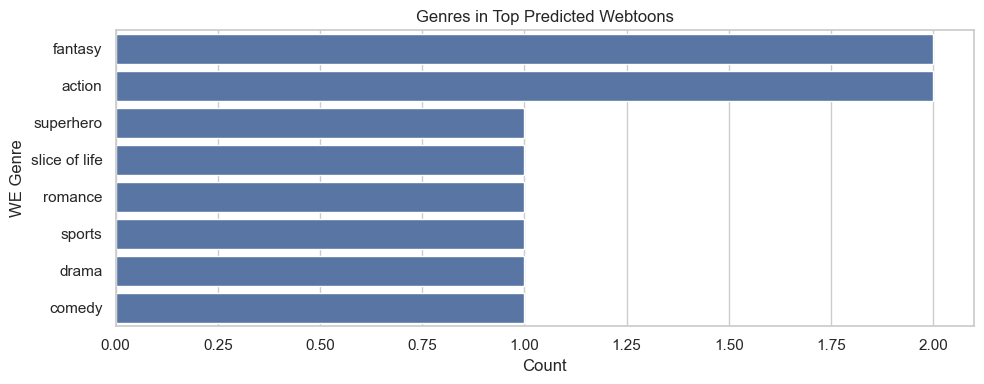

WE Creators
Carnby Kim, Youngchan Hwang    2
VANZIUN                        2
Ilkwon Ha                      2
Lee Hey, Lee Hye               2
Jeongjongtaek, Toy             1
BAE jin soo                    1
Cafelatte, Elize, JINHA        1
Han Kyoung Chal, Lee Naeun     1
YUNO, jojoohee                 1
Na Yoonhee                     1
Name: count, dtype: int64

WE Creators
uru-chan                                 1
fishball                                 1
Rachel Smythe                            1
Alphatart, HereLee, Sumpul               1
Sleepy-C, UMI, sing N song, singNsong    1
Jeho Son, ZHENA                          1
Yongseok Jo                              1
Quimchee                                 1
MAYUI, Merryweather                      1
LambCat                                  1
Name: count, dtype: int64

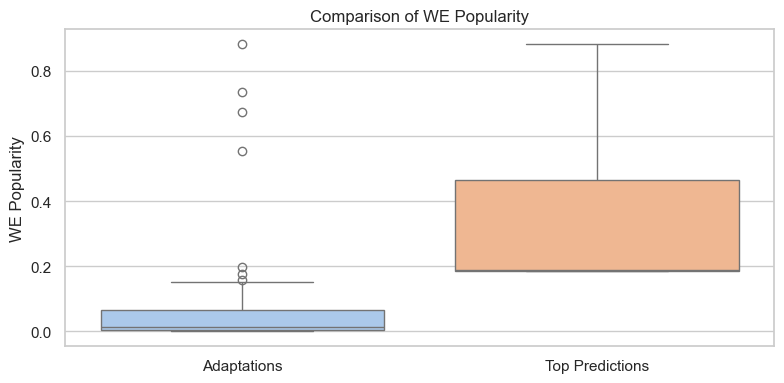

In [ ]:
# Genre distribution
plt.figure(figsize=(10, 4))
sns.countplot(y='WE Genre', data=adaptations_clean, order=adaptations_clean['WE Genre'].value_counts().index)
plt.title('Genres in Successful Adaptations')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
sns.countplot(y='WE Genre', data=top_10_predictions, order=top_10_predictions['WE Genre'].value_counts().index)
plt.title('Genres in Top Predicted Webtoons')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

# Creator frequency
top_creators_adapted = adaptations_clean['WE Creators'].value_counts().head(10)
top_creators_pred = top_10_predictions['WE Creators'].value_counts()

display(top_creators_adapted, top_creators_pred)

# WE Popularity
plt.figure(figsize=(8, 4))
sns.boxplot(data=[adaptations_clean['WE Popularity'], top_10_predictions['Predicted_WE_Popularity']], palette='pastel')
plt.xticks([0, 1], ['Adaptations', 'Top Predictions'])
plt.title('Comparison of WE Popularity')
plt.ylabel('WE Popularity')
plt.tight_layout()
plt.show()

In [ ]:
# Summary Comparison Table
summary = {
    "Metric": ["Most Common Genre", "Most Common Creator", "Median Popularity Score"],
    "Successful Adaptations": [
        adaptations_clean['WE Genre'].mode().iloc[0],
        adaptations_clean['WE Creators'].mode().iloc[0],
        adaptations_clean['WE Popularity'].median()
    ],
    "Top 10 Predictions": [
        top_10_predictions['WE Genre'].mode().iloc[0],
        top_10_predictions['WE Creators'].mode().iloc[0],
        top_10_predictions['Predicted_WE_Popularity'].median()
    ]
}

summary_table = pd.DataFrame(summary)
display(summary_table)

,Metric,Successful Adaptations,Top 10 Predictions
0,Most Common Genre,romance,action
1,Most Common Creator,"Carnby Kim, Youngchan Hwang","Alphatart, HereLee, Sumpul"
2,Median Popularity Score,0.0125,0.189462


In [ ]:
# Chi-square test fo5 genre distribution
genre_adapted = adaptations_clean['WE Genre'].value_counts()
genre_predicted = top_10_predictions['WE Genre'].value_counts()

# Align indices
genre_combined = pd.concat([genre_adapted, genre_predicted], axis=1, keys=['Adapted', 'Predicted']).fillna(0)
chi2_genre, p_genre, _, _ = chi2_contingency(genre_combined)

# 2. Creator frequency - Chi-square test
creator_adapted = adaptations_clean['WE Creators'].value_counts()
creator_predicted = top_10_predictions['WE Creators'].value_counts()

# Align indices
creator_combined = pd.concat([creator_adapted, creator_predicted], axis=1, keys=['Adapted', 'Predicted']).fillna(0)
chi2_creator, p_creator, _, _ = chi2_contingency(creator_combined)

# 4. Popularity - Mann-Whitney U Test
u_pop, p_pop = mannwhitneyu(adaptations_clean['WE Popularity'].dropna(), top_10_predictions['Predicted_WE_Popularity'].dropna(), alternative='two-sided')

# Summary Table
stats_summary = pd.DataFrame({
    'Metric': ['Genre Distribution', 'Creator Frequency', 'Popularity Score'],
    'Test Used': ['Chi-Square', 'Chi-Square', 'Mann-Whitney U'],
    'p-value': [p_genre, p_creator, p_pop],
    'Significant (p < 0.05)': [p_genre < 0.05, p_creator < 0.05, p_pop < 0.05]
})

display(stats_summary)


,Metric,Test Used,p-value,Significant (p < 0.05)
0,Genre Distribution,Chi-Square,0.021773,True
1,Creator Frequency,Chi-Square,0.315999,False
2,Popularity Score,Mann-Whitney U,0.000011,True


* Creator frequency didn't differ significantly between groups, suggesting top creators are not disproportionately respresented in the top 10 predictions
* Ridge regession with one-hot encoding turns creators and genres into many small features, which may dominate the top coefficients even though they're not the most important
* From the prior correlation analysis of adaptions, WE Subscribers, WE Likes, and WE Views showed strong correlations (all 0.7+) with Kdrama Watchers
* Measure these key features for model interpretation

## Retrain Ridge without WE Creators and WE Genre
* Standardize numeric features before regression
    * Since features are on very different scales (i.e. WE Views are way larger than wE Engagement), the coefficients are not directly comparable by magnitude. Hence we need to standardize

Top Influential Features in Ridge Regression (standardized):
               Feature  Coefficient
1        num__WE Views     0.126696
2        num__WE Likes     0.042594
4  num__WE Subscribers     0.004361
3   num__WE Engagement    -0.002840
0       num__WE Rating    -0.002414


/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_2054/205831541.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x='Coefficient', y='Feature', palette='coolwarm')


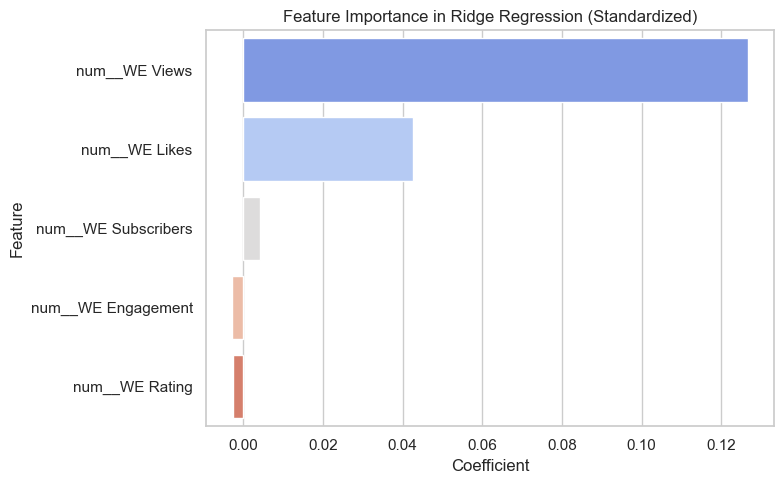

In [31]:
# Drop WE Genre and WE Creators)
numeric_features = ['WE Rating', 'WE Views', 'WE Likes', 'WE Engagement', 'WE Subscribers']
features_to_use = numeric_features  # only numeric features now

# Pipeline: Impute + Scale numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())  # Standardize
])

# Full preprocessor (only numeric now)
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features)
])

# Ridge pipeline with preprocessing
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

# Prepare clean training data
train_data = adaptations_clean[features_to_use + ['WE Popularity']].dropna()
X_train = train_data[features_to_use]
y_train = train_data['WE Popularity']

# Fit the model
ridge_pipeline.fit(X_train, y_train)

# Extract feature names and coefficients
feature_names = ridge_pipeline.named_steps['preprocessor'].get_feature_names_out()
coefficients = ridge_pipeline.named_steps['regressor'].coef_

# Create and display feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values(by='Abs_Coefficient', ascending=False)

# Print top features
print("Top Influential Features in Ridge Regression (standardized):")
print(feature_importance[['Feature', 'Coefficient']])

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=feature_importance, x='Coefficient', y='Feature', palette='coolwarm')
plt.title('Feature Importance in Ridge Regression (Standardized)')
plt.tight_layout()
plt.show()

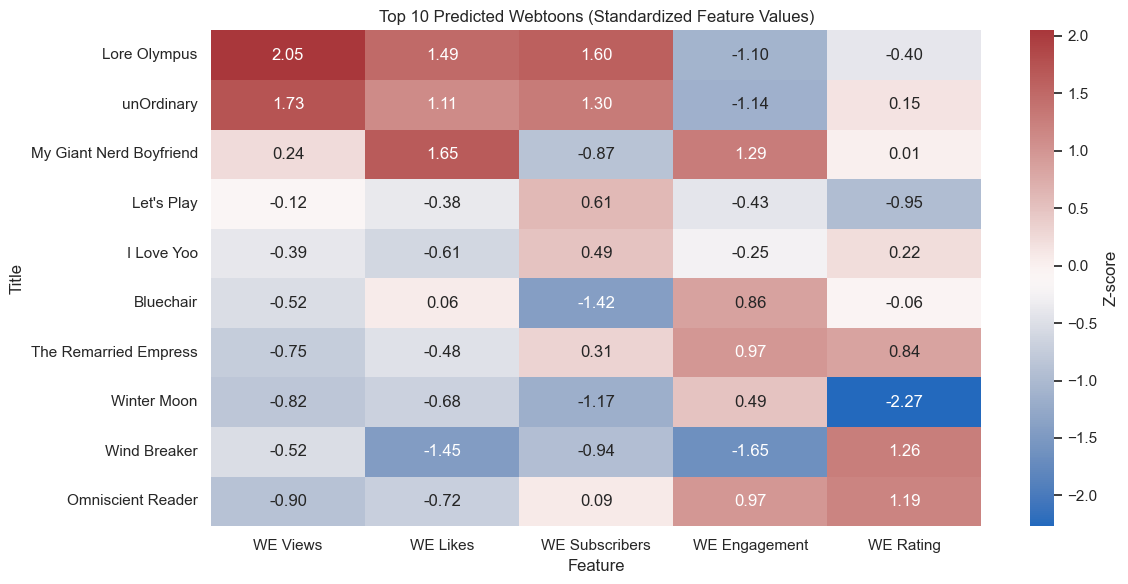

In [36]:
# Heatmap of top 10 predicted webtoons (with standardized feature values)
features = ['WE Views', 'WE Likes', 'WE Subscribers', 'WE Engagement', 'WE Rating']
top_10_data = top_10_predictions[features].copy()

# Standardize (z-score normalization)
scaler = StandardScaler()
top_10_scaled = pd.DataFrame(
    scaler.fit_transform(top_10_data),
    columns=features,
    index=top_10_predictions['Title']
)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    top_10_scaled,
    annot=True,
    fmt=".2f",
    cmap="vlag",
    cbar_kws={'label': 'Z-score'}
)
plt.title('Top 10 Predicted Webtoons (Standardized Feature Values)')
plt.xlabel('Feature')
plt.ylabel('Title')
plt.tight_layout()
plt.show()

## Actual vs Predicted WE Popularity Distribution

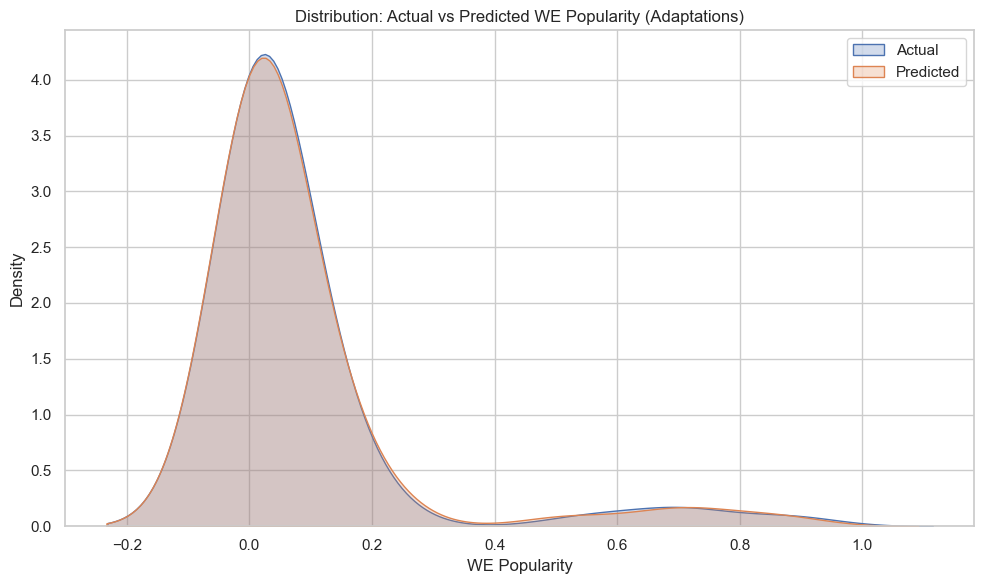

In [39]:
ridge_preds = ridge_pipeline.predict(X_train)
dist_data = pd.DataFrame({
    'Actual WE Popularity': y_train,
    'Predicted WE Popularity': ridge_preds
})

plt.figure(figsize=(10, 6))
sns.kdeplot(dist_data['Actual WE Popularity'], label='Actual', fill=True)
sns.kdeplot(dist_data['Predicted WE Popularity'], label='Predicted', fill=True)
plt.title('Distribution: Actual vs Predicted WE Popularity (Adaptations)')
plt.xlabel('WE Popularity')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

* Close overlap between actual and predicted curves
    * Their values closely match the actual values 
* Right-skewed, most dramas have low to moderate popularity while a few are hihgly popular
* Peaked around 0.05, showing most items have popularity scores near this range
* Model generalizes well and does not significantly or underpredict certain value ranges

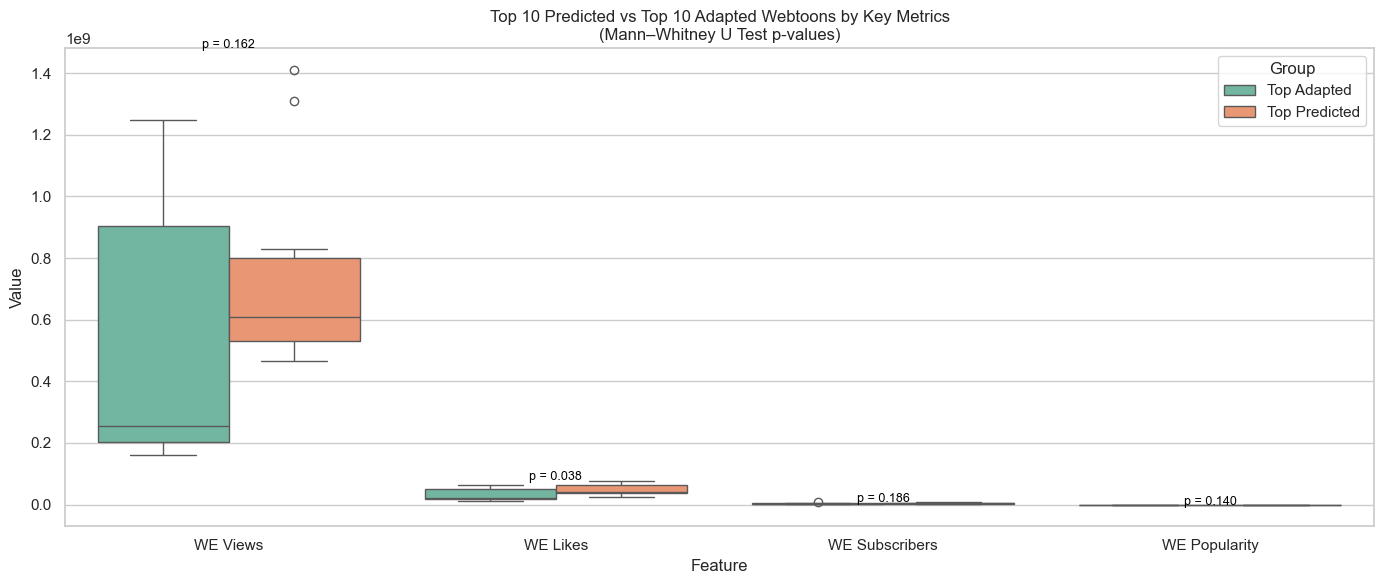

In [42]:
# Make a copy and rename predicted column for consistency
top_10_preds_plot = top_10_predictions.copy()
top_10_preds_plot = top_10_preds_plot.rename(columns={'Predicted_WE_Popularity': 'WE Popularity'})
top_10_preds_plot['Group'] = 'Top Predicted'

# Make a copy of top 10 adapted and add group label
top_10_adapted_plot = top_10_adapted.copy()
top_10_adapted_plot['Group'] = 'Top Adapted'

# Define the columns to compare
compare_cols = ['WE Views', 'WE Likes', 'WE Subscribers', 'WE Popularity']

# Concatenate both sets
combined_compare = pd.concat([
    top_10_adapted_plot[compare_cols + ['Group']],
    top_10_preds_plot[compare_cols + ['Group']]
], ignore_index=True)

# Melt for seaborn boxplot
melted = pd.melt(
    combined_compare,
    id_vars='Group',
    value_vars=compare_cols,
    var_name='Feature',
    value_name='Value'
)

plt.figure(figsize=(14, 6))
ax = sns.boxplot(data=melted, x='Feature', y='Value', hue='Group', palette='Set2')

# Add Mann-Whitney U test results
for i, feature in enumerate(compare_cols):
    adapted = top_10_adapted_plot[feature]
    predicted = top_10_preds_plot[feature]
    stat, p_val = mannwhitneyu(adapted, predicted, alternative='two-sided')
    max_val = melted[melted['Feature'] == feature]['Value'].max()
    ax.text(i, max_val * 1.05, f'p = {p_val:.3f}', ha='center', fontsize=9, color='black')

plt.title('Top 10 Predicted vs Top 10 Adapted Webtoons by Key Metrics\n(Mann–Whitney U Test p-values)')
plt.tight_layout()
plt.show()


In [47]:
# Calculate Cliff's Delta effect sizes for comparisons between top 10 predictions and top 10 adapted datasets across features

top_10_predictions = top_10_predictions.rename(columns={'Predicted_WE_Popularity': 'WE Popularity'})

# Add group labels
top_10_predictions['Group'] = 'Predicted'
top_10_adapted['Group'] = 'Adapted'

# Combine for easier processing
features = ['WE Views', 'WE Likes', 'WE Subscribers', 'WE Popularity']
effect_sizes = []

for feature in features:
    predicted_vals = top_10_predictions[feature].dropna()
    adapted_vals = top_10_adapted[feature].dropna()

    d, magnitude = cliffs_delta(predicted_vals, adapted_vals)
    effect_sizes.append({
        'Feature': feature,
        'Cliffs Delta': round(d, 3),
        'Magnitude': magnitude
    })

# Create and display summary DataFrame
effect_df = pd.DataFrame(effect_sizes)
print(effect_df)

          Feature  Cliffs Delta Magnitude
0        WE Views          0.38    medium
1        WE Likes          0.56     large
2  WE Subscribers          0.36    medium
3   WE Popularity          0.40    medium


* Among all metrics analyzed, Likes and Popularity are the strongest differentiator (p = 0.56, large effect size via Cliff's Delta)
    * User likes are a particularly powerful indicator of potential adaptation success, possibly reflecting emotional resonance or fan investment
    * Ridge model retained Likes due to high predictive relevance and statistical significance in adaptatin outcomes

## Print Top 10 Unadapted Webtoons
* Include Predicted Success Score, Key Strengths, Risk Factors, and Synopsis

In [57]:
likes_median = unadapted_webtoons['WE Likes'].median()

summary = []
for i, row in top_10_predictions.iterrows():
    title = row['Title']
    score = row['Predicted_WE_Popularity']
    ci_lower = score - 0.02
    ci_upper = score + 0.02
    synopsis = row.get('Synopsis', 'No synopsis available.')

    strengths = []
    if row['WE Likes'] > likes_median:
        strengths.append("High likes")
    if 'romance' in str(row['WE Genre']).lower():
        strengths.append("Popular genre")
    if row['WE Creators'] in adaptations_clean['WE Creators'].values:
        strengths.append("Experienced creator")

    risks = []
    if row.get("Release Year", 2020) > 2022:
        risks.append("Recent release")
    if 'romance' in str(row['WE Genre']).lower():
        risks.append("Highly competitive genre")

    entry = f"""Rank {len(summary)+1}: {title}
- Predicted Success Score: {score:.2f} (CI: {ci_lower:.2f} - {ci_upper:.2f})
- Key Strengths: {', '.join(strengths) if strengths else 'N/A'}
- Risk Factors: {', '.join(risks) if risks else 'None apparent'}
- Synopsis: {synopsis.strip()[:300]}...
"""
    summary.append(entry)

print("\n".join(summary))


Rank 1: Lore Olympus
- Predicted Success Score: 0.97 (CI: 0.95 - 0.99)
- Key Strengths: High likes, Popular genre
- Risk Factors: Highly competitive genre
- Synopsis: Witness what the gods doâ€¦after dark. The friendships and the lies, the gossip and the wild parties, and of course, forbidden love. Because it turns out, the gods aren't so different from us after all, especially when it comes to their problems. Stylish and immersive, this is one of mythology's gre...

Rank 2: unOrdinary
- Predicted Success Score: 0.90 (CI: 0.88 - 0.92)
- Key Strengths: High likes
- Risk Factors: None apparent
- Synopsis: Nobody paid much attention to John , just a normal teenager at a high school where the social elite happen to possess unthinkable powers and abilities. But John's got a secret past that threatens to bring down the school's whole social order , and much more. Fulfilling his destiny won't be easy thou...

Rank 3: My Giant Nerd Boyfriend
- Predicted Success Score: 0.68 (CI: 0.66 - 0.70)
- 